In [1]:
'''
MODELLING - RANDOM FOREST
'''

'\nMODELLING - RANDOM FOREST\n'

In [2]:
import os
import itertools
import optuna
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import sklearn.model_selection
import sklearn.metrics

c:\Users\davib\Downloads\EQE778_Trabalho_Individual\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Model identification
MODEL_ID = '03'

# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [4]:
# Import x and y dataframes
df_scaled_x = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_x.joblib'))
df_scaled_y = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_y.joblib'))

df_scaled_y = df_scaled_y.drop(columns=['H2S_ppm'])

x_scaled = df_scaled_x.values
y_scaled = df_scaled_y.values

print(f"x scaled shape: {x_scaled.shape}")
print(f"y scaled shape: {y_scaled.shape}")

x scaled shape: (897254, 5)
y scaled shape: (897254, 1)


In [5]:
# separando os dados entre treinamento e teste
train_data, test_data, train_output, test_output = train_test_split(x_scaled, y_scaled, test_size=0.10, random_state=42, shuffle=True)
print(train_data.shape)
print(test_data.shape)
print(train_output.shape)
print(test_output.shape)

(807528, 5)
(89726, 5)
(807528, 1)
(89726, 1)


In [ ]:
# Otimização de Hiperparâmetros
def objetivo_rc(trial):
    # Hiperparâmetros de busca para RF
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 300)
    rf_max_depth = trial.suggest_int("rf_max_depth", 10, 50)       
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 20)    

    # Criação do modelo RF
    m = sklearn.ensemble.RandomForestRegressor(
        min_samples_leaf = rf_min_samples_leaf,
        min_samples_split = rf_min_samples_split,
        max_depth = rf_max_depth,         
        n_estimators = rf_n_estimators,
        n_jobs=-1)

    # Retornando R² de validação, 20% dos dados de treino
    train__data, val_data, train__output, val_output = sklearn.model_selection.train_test_split(train_data, train_output, test_size=0.2, random_state=101) 
    
    # Converter train__output para vetor unidimensional
    train__output = train__output.ravel()

    m.fit(train__data, train__output)
    predictions_optimization = m.predict(val_data)

    r2 = sklearn.metrics.r2_score(val_output, predictions_optimization)

    #r2 = sklearn.metrics.mean_absolute_error(val_output, predictions_optimization) # se for usar Mean Absolute Error
    #r2 = sklearn.metrics.mean_squared_error(val_output, predictions_optimization) # se for usar Mean Squared Error
    #r2 = np.sqrt(sklearn.metrics.mean_squared_error(val_output, predictions_optimization)) se for usar Root Mean Squared Error

    # Salvando o modelo treinado
    joblib.dump(m, f'{OUTPUT_FOLDER}/model_{MODEL_ID}_temp_{str(trial.number)}.joblib')

    return r2

# Resultados função objetivo
study_rc = optuna.create_study(direction="maximize")
n_trials = 40
print("Nº Iterações Otimização:", n_trials)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rc.optimize(objetivo_rc, n_trials=n_trials, show_progress_bar=True)
print("Hiperparâmetros Otimizados:", study_rc.best_params)
print("Melhor trial:", study_rc.best_trial.number)

[I 2024-12-02 12:42:25,929] A new study created in memory with name: no-name-024eaec0-3e6e-4f02-b8df-c62d09b9a3b3


Nº Iterações Otimização: 40


Best trial: 16. Best value: 0.283011: 100%|██████████| 40/40 [08:11<00:00, 12.28s/it]

Hiperparâmetros Otimizados: {'rf_n_estimators': 246, 'rf_max_depth': 14, 'min_samples_split': 13, 'rf_min_samples_leaf': 18}
Melhor trial: 16


In [7]:
# Carregamento e teste do modelo RF com hiperparâmetros otimizados
loaded_model = joblib.load(f'{OUTPUT_FOLDER}/model_{MODEL_ID}_temp_{str(study_rc.best_trial.number)}.joblib')
predictions = loaded_model.predict(test_data)  # teste
predictions_train = loaded_model.predict(train_data)  # treino

In [8]:
# Apagando modelos após uso
folder_path = os.path.join(os.getcwd(), OUTPUT_FOLDER)
for filename in os.listdir(folder_path):
    if filename.startswith(f"model_{MODEL_ID}_temp"):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            os.remove(filepath)

In [9]:
print('Métricas Modelo - dados teste')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(test_output, predictions))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(test_output, predictions))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(test_output, predictions)))
print('R^2:', sklearn.metrics.r2_score(test_output, predictions))

Métricas Modelo - dados teste
Mean Absolute Error: 0.6695281898528218
Mean Squared Error: 0.7220226575573699
Root Mean Squared Error: 0.8497191639343966
R^2: 0.28131981018858676


In [10]:
print('Métricas Modelo - dados treino')
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(train_output, predictions_train))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(train_output, predictions_train))
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(train_output, predictions_train)))
print('R^2:', sklearn.metrics.r2_score(train_output, predictions_train))

Métricas Modelo - dados treino
Mean Absolute Error: 0.6524529774972208
Mean Squared Error: 0.6865146821670001
Root Mean Squared Error: 0.8285618155376219
R^2: 0.3131303565650223


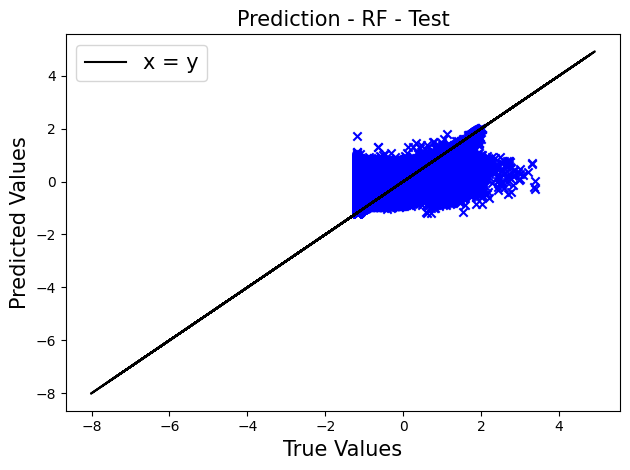

In [11]:
# Gráfico predição ingles - teste
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(test_output, predictions, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - RF - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_testpredictions_eng.png')
plt.show()
plt.close()

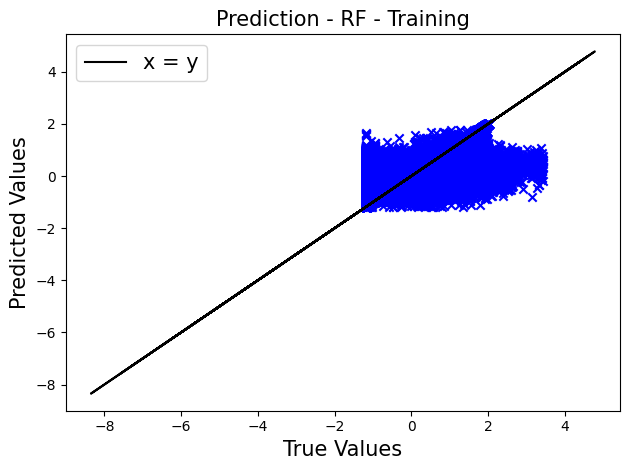

In [12]:
# Gráfico predição ingles - treinamento
plt.figure()
reta = np.random.uniform(low=-8.5, high=5, size=(50, ))
plt.plot(reta, reta, color='black', label='x = y')  #plot reta x = y
plt.scatter(train_output, predictions_train, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - RF - Training', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_trainpredictions_eng.png')
plt.show()
plt.close()

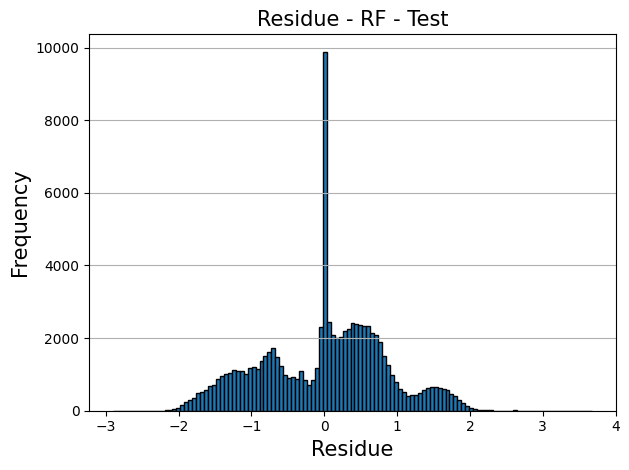

In [13]:
# Gráfico Resíduos ingles - teste
residue = test_output.ravel() - predictions.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF - Test', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_testresidue_eng.png')
plt.show()
plt.close()

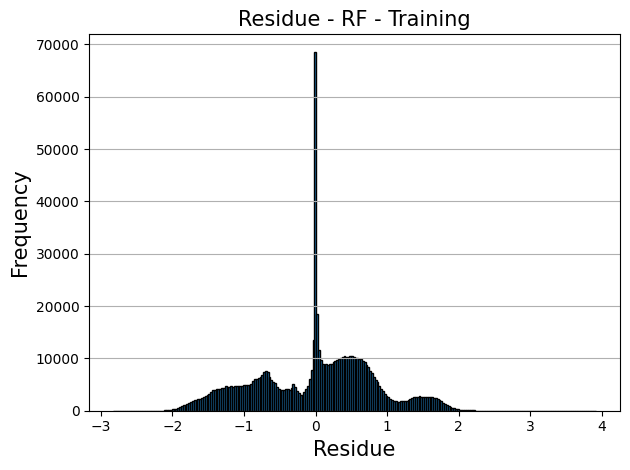

In [14]:
# Gráfico Resíduos ingles - treinamento
residue = train_output.ravel() - predictions_train.ravel()
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - RF - Training', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_trainresidue_eng.png')
plt.show()
plt.close()

In [15]:
# Importância das variáveis
header = df_scaled_x.columns

importances = list(loaded_model.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(header, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
[print('Variável: {:20} Importância: {}'.format(*pair)) for pair in feature_importances]

# Ajuste do tamanho do header
adjusted_header = list(itertools.islice(header, len(importances)))

Variável: feedNH3              Importância: 0.3808
Variável: feedH2S              Importância: 0.2295
Variável: QN1                  Importância: 0.1806
Variável: QN2                  Importância: 0.1709
Variável: SF                   Importância: 0.0382


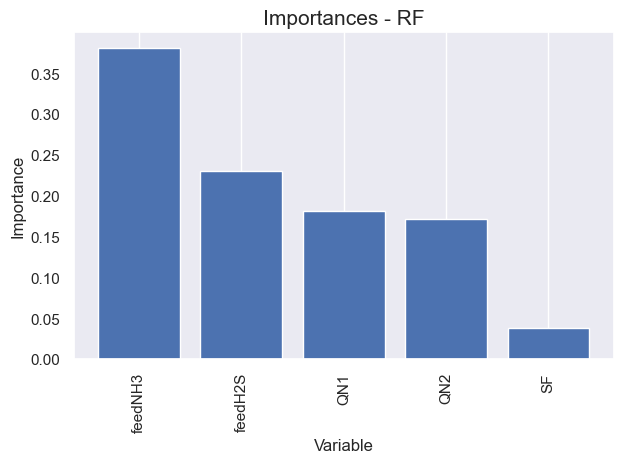

In [16]:
# Gráfico importância ingles
sns.set(font_scale=1)
x_values = list(range(len(importances)))
plt.figure()
plt.grid(axis='y')
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, adjusted_header, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Importances - RF', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_RF_importance_eng.png')
plt.show()
plt.close()